In [82]:

### f(x)=a*x+b


# import vine dataset
import torch

import pandas as pd
import numpy as np
from sklearn.datasets import load_wine


wine = load_wine()
wine.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [83]:
df=pd.DataFrame(data=wine.data,columns=wine.feature_names)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [84]:
y=df['alcohol']
X=df.drop(['alcohol'],axis=1)


#scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [85]:
X_train.shape

(142, 12)

In [86]:
# pytorch model
import torch.nn as nn


class MySimpleModel(nn.Module):
    def __init__(self):  # constructor, is called when the object is created
        super(MySimpleModel, self).__init__()
        self.fc = nn.Linear(12,200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,1)
        self.relu=nn.ReLU()

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

model=MySimpleModel()
for param, name in zip(model.parameters(), model.state_dict()):
    print(name, param.shape)

fc.weight torch.Size([200, 12])
fc.bias torch.Size([200])
fc2.weight torch.Size([100, 200])
fc2.bias torch.Size([100])
fc3.weight torch.Size([1, 100])
fc3.bias torch.Size([1])


In [87]:
class MySimpleDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):   # ds = MySimpleDataset(X, y)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):    # len(ds)
        return len(self.X)

    def __getitem__(self, idx):  # ds[0]
        return self.X[idx], self.y[idx]
    

train_ds = MySimpleDataset(X_train, y_train.values)
test_ds = MySimpleDataset(X_test, y_test.values)

train_ds[0]

(tensor([-0.5892,  1.2190,  1.6531, -0.1223,  0.8090, -0.7221,  1.3549,  1.9432,
          3.4354, -1.6999, -0.9205, -0.2767]),
 tensor(14.3400))

In [88]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

In [89]:
def get_test_loss(model
                  , test_dl
                  , loss_fn):
    with torch.no_grad():
        test_loss = 0
        for X_batch, y_batch in test_dl:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            test_loss += loss.item()
    return test_loss / len(test_dl)

In [90]:


def mse_loss(y_pred,y):
    return torch.mean((y_pred-y)**2)

In [91]:
X_train=torch.tensor(X_train,dtype=torch.float32)
y_train=torch.tensor(y_train.values,dtype=torch.float32)
X_test=torch.tensor(X_test,dtype=torch.float32)
y_test=torch.tensor(y_test.values,dtype=torch.float32)


100%|██████████| 3000/3000 [00:10<00:00, 278.02it/s, test_loss=0.453, train_loss=0.0257]


train_losses 0.025654773896848653
test_losses 0.4530850946903229


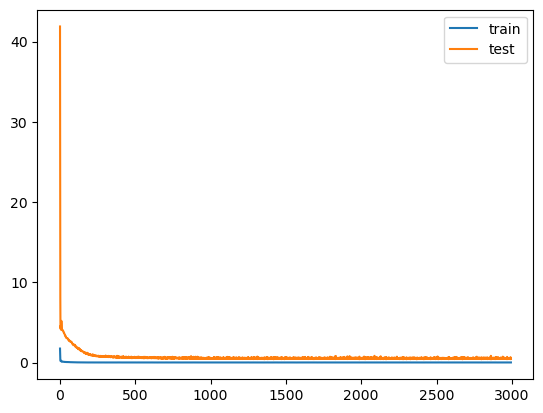

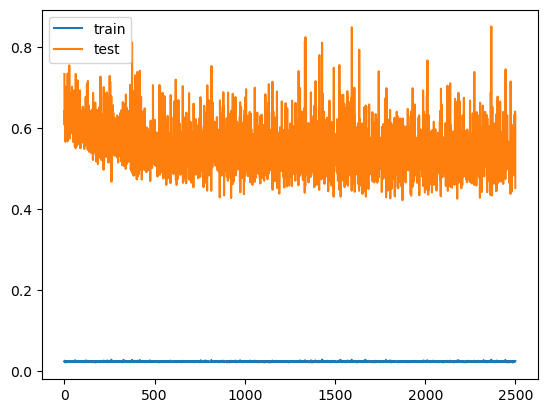

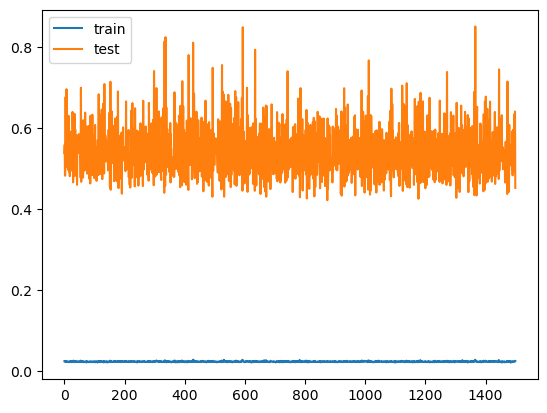

In [92]:
hidden_size = 20
from tqdm import tqdm


# set torch seed to 42
torch.manual_seed(42)


model=MySimpleModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

epochs=3000
lr=0.0001
wd=0.01

import matplotlib.pyplot as plt

train_losses=[]
test_losses=[]
bar=tqdm(range(epochs))
for epoch in bar:
    epoch_loss=0
    for xb, yb in train_dl:
        y_pred=model(xb)
        loss=mse_loss(y_pred, yb)
        loss.backward()
        epoch_loss+=loss.item()
        optimizer.step()
        optimizer.zero_grad()  
    test_loss=get_test_loss(model,test_dl,mse_loss)
    test_losses.append(test_loss)
    train_losses.append(epoch_loss/len(X_train))
    bar.set_postfix(train_loss=train_losses[-1],test_loss=test_losses[-1])


print("train_losses",train_losses[-1])
print("test_losses",test_losses[-1])
plt.plot(train_losses[5:], label='train')
plt.plot(test_losses[5:], label='test')
plt.legend()
plt.show()


plt.plot(train_losses[500:], label='train')
plt.plot(test_losses[500:], label='test')
plt.legend()
plt.show()

plt.plot(train_losses[1500:], label='train')
plt.plot(test_losses[1500:], label='test')
plt.legend()
plt.show()

In [93]:
y_test_pred=model(X_test)

for i in range(15):
    print(y_test_pred[i].item(),y_test[i].item())

13.198758125305176 13.640000343322754
13.10755443572998 14.210000038146973
13.164448738098145 12.930000305175781
13.217106819152832 13.729999542236328
13.132088661193848 12.369999885559082
13.1903715133667 14.300000190734863
12.994985580444336 12.0
13.056414604187012 13.399999618530273
13.269211769104004 11.609999656677246
13.13725757598877 13.359999656677246
13.227803230285645 13.5
13.153181076049805 13.5
13.058232307434082 13.40999984741211
13.03701114654541 12.770000457763672
13.220552444458008 13.630000114440918
